In [1]:
import os
import numpy as np
import pandas as pd
import random
import shutil
import warnings
from PIL import Image # image processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory # load images from directory
from tensorflow.keras import callbacks # use EarlyStopping
from tensorflow.keras.preprocessing import image
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

2024-07-23 06:43:01.464221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 06:43:01.464349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 06:43:01.611673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv('/kaggle/input/thcr-1/train.csv')
df_test = pd.read_csv('/kaggle/input/thcr-1/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62870 entries, 0 to 62869
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           62870 non-null  object
 1   Class Label  62870 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 982.5+ KB


In [4]:
df_train.head()

,ID,Class Label
0,1.bmp,2
1,2.bmp,3
2,3.bmp,4
3,4.bmp,5
4,5.bmp,6


In [5]:
width, height = Image.open(
    '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/1.bmp'
).size
print(f'Width: {width}px, Height: {height}px')

Width: 64px, Height: 64px


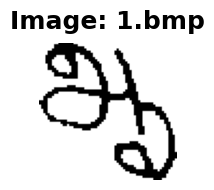

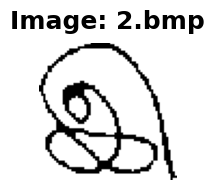

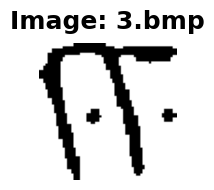

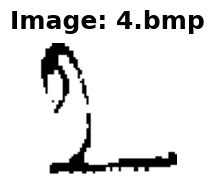

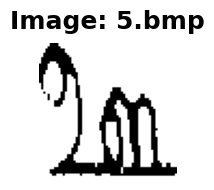

In [6]:
examples = 5 

for index in range(examples):
    image_file = df_train['ID'][index]
    
    image_path = os.path.join(
        '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle',
        image_file
    )
    img = Image.open(image_path)
    
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.title(f'Image: {image_file}')
    plt.axis('off')
    plt.show()

In [7]:
label = 'Class Label'
len(df_train[label].unique())
print(df_train[label].unique())

[  2   3   4   5   6   7   9  10  11  12  14  15  16  17  19  20  13  18
   0  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155   8  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79   1  80]


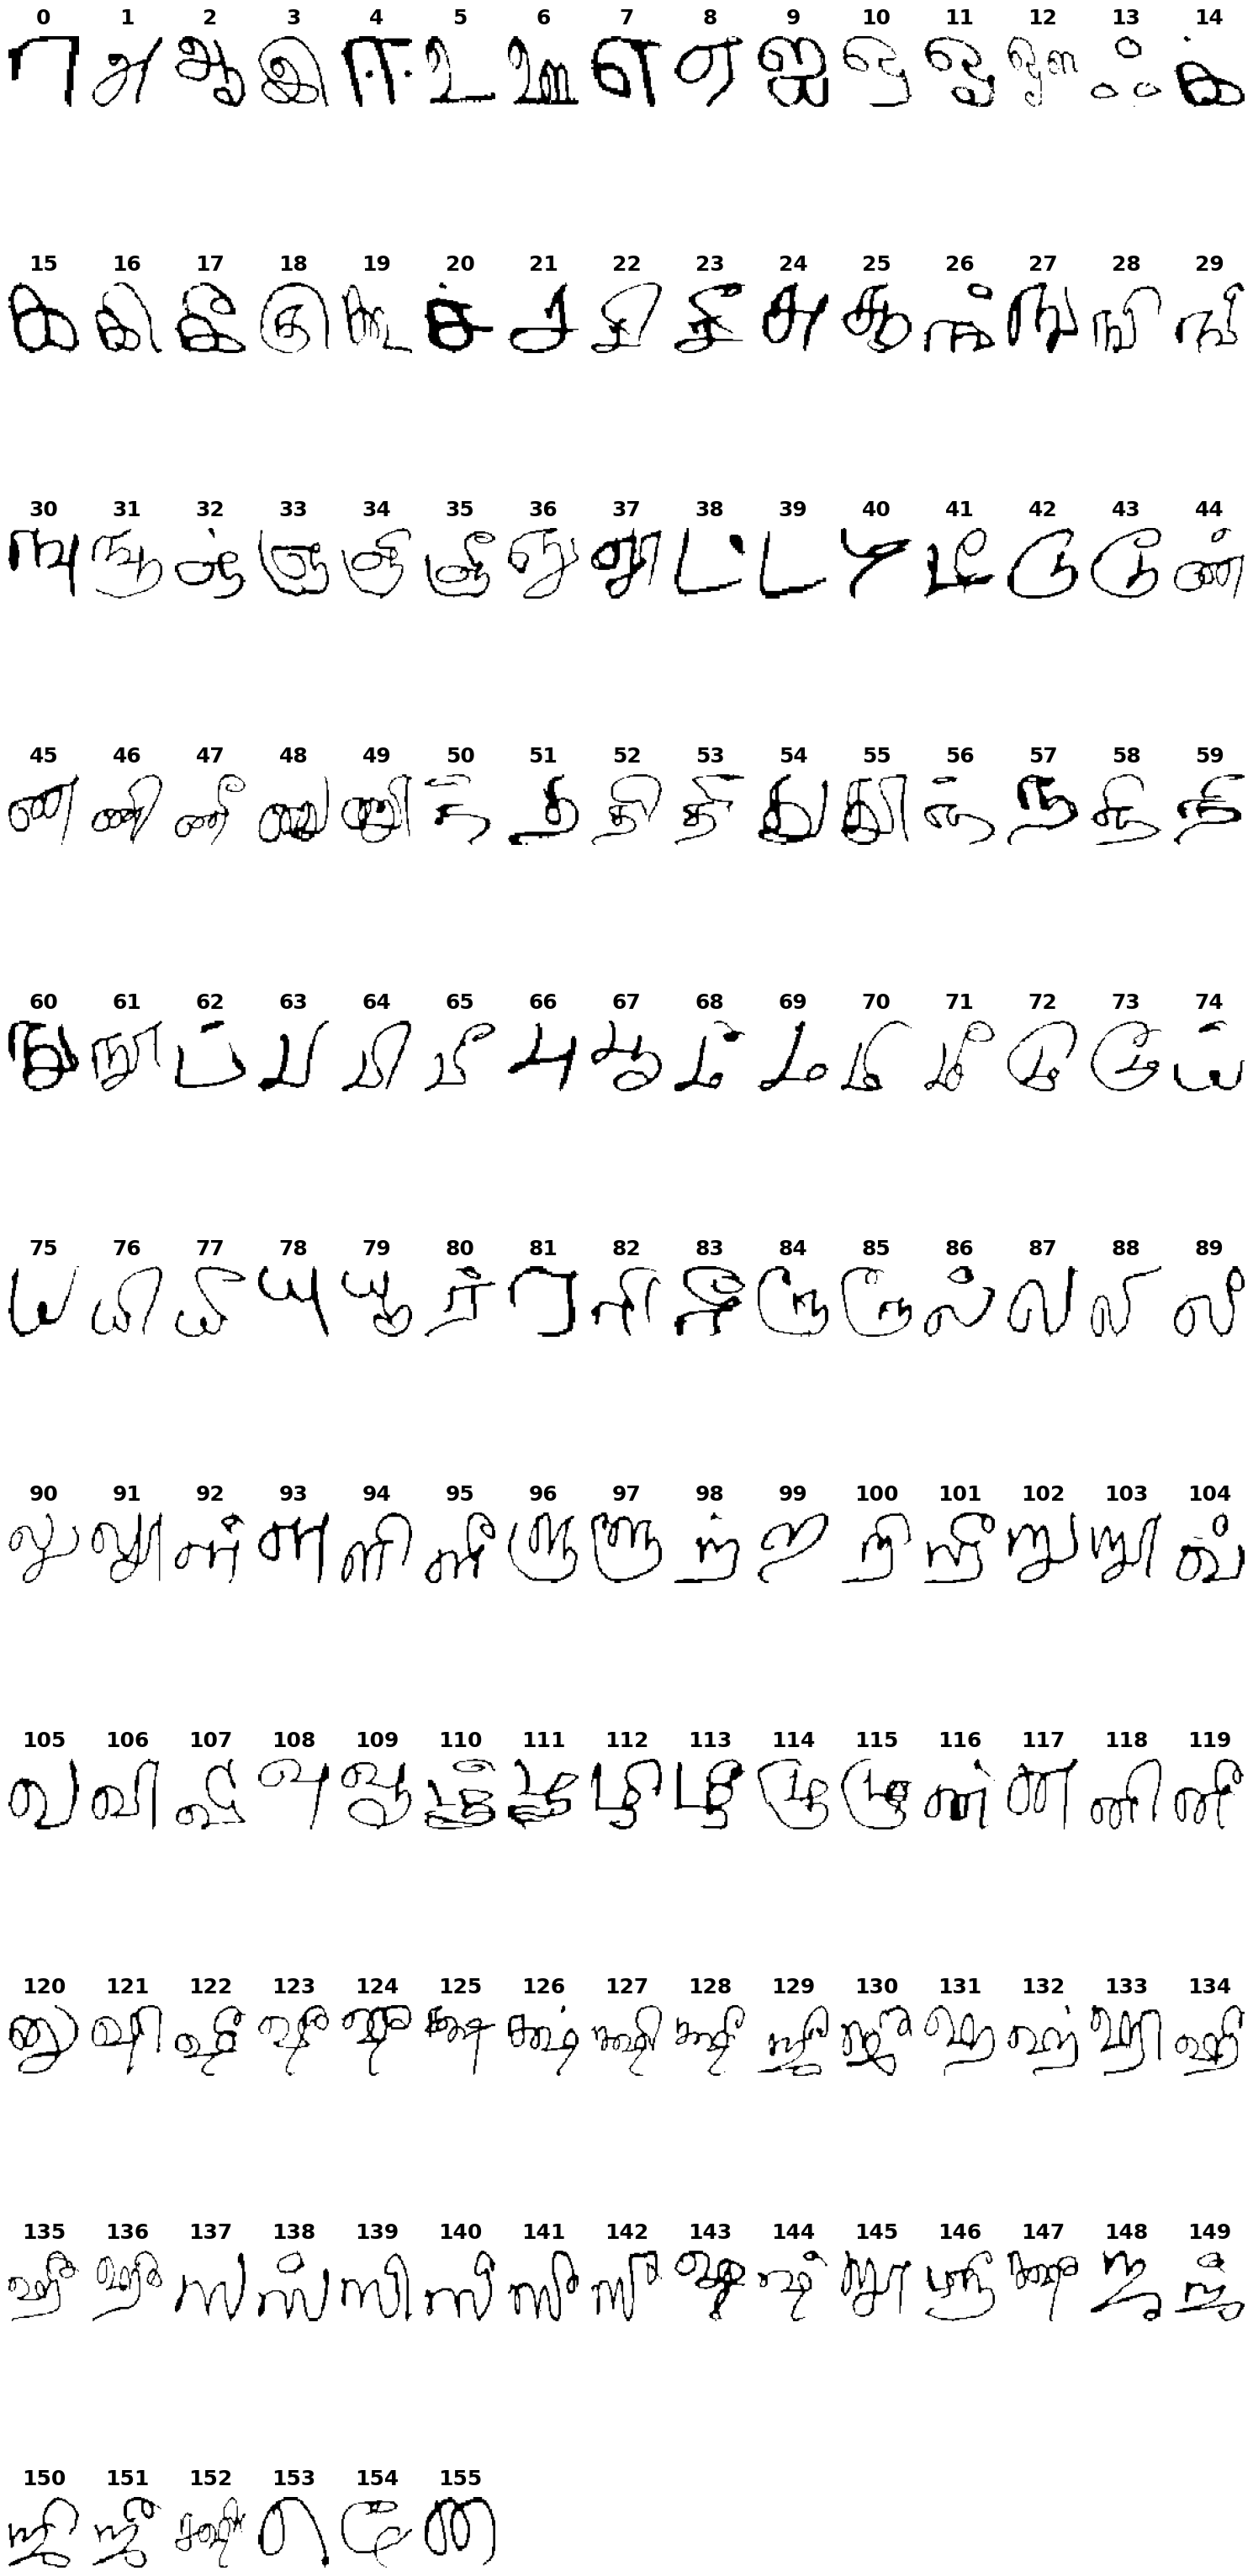

In [8]:
num_classes = df_train['Class Label'].nunique()
num_cols = 15
num_rows = (num_classes // num_cols) + 1

plt.figure(figsize=(15, 3 * num_rows))


for i, class_label in enumerate(sorted(df_train['Class Label'].unique()), start=1):
    image_dir='/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle'
    class_df = df_train[df_train['Class Label'] == class_label]
    row = class_df.iloc[0]
    image_path = image_dir + "/" + row['ID']
    image = Image.open(image_path)
    image = image.resize((64, 64))  
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(image)
    plt.title(class_label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
tamil_characters = ['ா', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'ஔ','ஃ','க்','க', 'கி', 'கீ', 'கு', 'கூ','ச்', 'ச','சி', 'சீ', 'சு','சூ','ங்', 'ங', 'ஙி', 'ஙீ', 'ஙு', 'ஙூ','ஞ்','ஞ','ஞி','ஞீ','ஞு','ஞூ','ட்','ட',"ழ",'டீ','டு','டூ','ண்','ண', 'ணி','ணீ','ணு','ணூ','த்','த', 'தி', 'தீ', 'து', 'தூ','ந்', 'ந', 'நி', 'நீ', 'நு', 'நூ','ப்','ப', 'பி', 'பீ', 'பு', 'பூ', 'ம்','ம', 'மி', 'மீ', 'மு', 'மூ','ய்','ய', 'யி', 'யீ', 'யு', 'யூ','ர்', 'ர', 'ரி', 'ரீ', 'ரு', 'ரூ', 'ல்','ல', 'லி', 'லீ', 'லு', 'லூ', 'ன்',  'ன', 'னி', 'னீ', 'ளு', 'ளூ', 'ற்','ற', 'றி', 'றீ', 'று', 'றூ', 'வ்','வ', 'வி', 'வீ', 'வு', 'வூ','ழ்','ழ', 'ழி', 'ழீ', 'ழு', 'ழூ','ன்', 'ன', 'னி',' னீ',' னு', 'ஷி', 'ஷீ', 'ஷு', 'ஷூ','க்ஷ', 'க்ஷ்',' க்ஷி',' க்ஷீ','ஜு', 'ஜூ','ஹ','ஹ்', 'ஹி', 'ஹீ', 'ஹு', 'ஹூ', 'ஸ','ஸ்', 'ஸி', 'ஸீ', 'ஸு', 'ஸூ', 'ஷ','ஷ்', 'னூ','ஶ்ரீ','க்ஷூ','ஜ','ஜ்','ஜி', 'ஜீ','க்ஷீ', 'ெ', 'ே', 'ை']# Creating a dictionary with characters as keys and their index as values
tamil_dict = {index: char for index, char in enumerate(tamil_characters)}
print(tamil_dict)

{0: 'ா', 1: 'அ', 2: 'ஆ', 3: 'இ', 4: 'ஈ', 5: 'உ', 6: 'ஊ', 7: 'எ', 8: 'ஏ', 9: 'ஐ', 10: 'ஒ', 11: 'ஓ', 12: 'ஔ', 13: 'ஃ', 14: 'க்', 15: 'க', 16: 'கி', 17: 'கீ', 18: 'கு', 19: 'கூ', 20: 'ச்', 21: 'ச', 22: 'சி', 23: 'சீ', 24: 'சு', 25: 'சூ', 26: 'ங்', 27: 'ங', 28: 'ஙி', 29: 'ஙீ', 30: 'ஙு', 31: 'ஙூ', 32: 'ஞ்', 33: 'ஞ', 34: 'ஞி', 35: 'ஞீ', 36: 'ஞு', 37: 'ஞூ', 38: 'ட்', 39: 'ட', 40: 'ழ', 41: 'டீ', 42: 'டு', 43: 'டூ', 44: 'ண்', 45: 'ண', 46: 'ணி', 47: 'ணீ', 48: 'ணு', 49: 'ணூ', 50: 'த்', 51: 'த', 52: 'தி', 53: 'தீ', 54: 'து', 55: 'தூ', 56: 'ந்', 57: 'ந', 58: 'நி', 59: 'நீ', 60: 'நு', 61: 'நூ', 62: 'ப்', 63: 'ப', 64: 'பி', 65: 'பீ', 66: 'பு', 67: 'பூ', 68: 'ம்', 69: 'ம', 70: 'மி', 71: 'மீ', 72: 'மு', 73: 'மூ', 74: 'ய்', 75: 'ய', 76: 'யி', 77: 'யீ', 78: 'யு', 79: 'யூ', 80: 'ர்', 81: 'ர', 82: 'ரி', 83: 'ரீ', 84: 'ரு', 85: 'ரூ', 86: 'ல்', 87: 'ல', 88: 'லி', 89: 'லீ', 90: 'லு', 91: 'லூ', 92: 'ன்', 93: 'ன', 94: 'னி', 95: 'னீ', 96: 'ளு', 97: 'ளூ', 98: 'ற்', 99: 'ற', 100: 'றி', 101: 'றீ', 102: 'று', 103: '

In [10]:
df_train[label].describe()

count    62870.000000
mean        77.601861
std         44.977283
min          0.000000
25%         39.000000
50%         78.000000
75%        116.000000
max        155.000000
Name: Class Label, dtype: float64

In [11]:
image_train_directory = '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle'
image_test_directory = '/kaggle/input/thcr-1/Test-Kaggle/Test-Kaggle'
df_train = df_train.sort_values(by='ID')
df_test = df_test.sort_values(by='ID')

In [12]:
train_labels = df_train[label].tolist()

train_ds, val_ds = image_dataset_from_directory(
    image_train_directory,
    labels=train_labels,
    label_mode='int',
    validation_split=0.2, # 20% for validation
    subset='both',
    seed=123, # no overlap of training and validation
    image_size=(64,64), 
    batch_size=32
)

test_ds = image_dataset_from_directory(
    image_test_directory,
    labels=None,
    label_mode=None,
    image_size=(64,64)
)

Found 62870 files belonging to 156 classes.
Using 50296 files for training.
Using 12574 files for validation.
Found 28080 files.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
class SelfAttention(layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        self.query_dense = layers.Dense(input_shape[-1])
        self.key_dense = layers.Dense(input_shape[-1])
        self.value_dense = layers.Dense(input_shape[-1])
        self.attention = layers.Attention()

    def call(self, inputs):
        queries = self.query_dense(inputs)
        keys = self.key_dense(inputs)
        values = self.value_dense(inputs)
        context = self.attention([queries, keys, values])
        return context

In [ ]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(64,64,3)),
    # Conv1
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    # Conv2
    layers.Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    # Conv3
    layers.Conv2D(filters=64, kernel_size=2, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.50),
    layers.Dense(units=156, activation='softmax')
])

In [ ]:
def create_model():
    inputs = tf.keras.Input(shape=(64, 64, 3))
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=2, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=2, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    
    
    x = layers.Conv2D(filters=64, kernel_size=1, activation='relu', padding='same')(x)
    x = layers.Reshape((-1, 64))(x)  
    x = SelfAttention()(x)
    x = layers.Reshape((64, 64, 64))(x)  
    
    x = layers.Flatten()(x)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(0.50)(x)
    outputs = layers.Dense(units=156, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = create_model()
model.summary()

In [15]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [16]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, 
    patience=3, 
    restore_best_weights=True
)

In [17]:
with tf.device('/CPU:0'):
    history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=100, 
                    verbose=1, 
                    callbacks=[early_stopping])

Epoch 1/100
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 119s 63ms/step - accuracy: 0.2749 - loss: 3.3233 - val_accuracy: 0.8715 - val_loss: 0.5289
Epoch 2/100


KeyboardInterrupt: 